# КАКОЙ КЕЙС РЕШАЕМ?

### Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

In [335]:
#загружаем необходимые библиотеки
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
import category_encoders as ce

#для синтементации отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
import os

# Библиотека для нормализации/масштабирования
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler # инструмент для масштабирования каждой функции до заданного диапазона

In [336]:
#зададим функцию для одинарного кодирования признака
def one_fot_encoding(df, column_name):
    encoder = ce.OneHotEncoder(cols=[column_name])
    type_bin = encoder.fit_transform(df[column_name])
    df = pd.concat([df, type_bin], axis=1)
    df.drop([column_name], axis=1, inplace=True) 
    
    return df

In [337]:
#зададим функцию для бинарного кодирования признака
def binary_encoding(df, column_name):
    bin_encoder = ce.BinaryEncoder(cols=[column_name])
    type_bin = bin_encoder.fit_transform(df[column_name])
    df = pd.concat([df, type_bin], axis=1)
    df.drop([column_name], axis=1, inplace=True)
    
    return df

In [338]:
#зададим функцию для создания коробчатой диаграммы
def Hist_and_Box_Plots(df, column_name, bins=30):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    axes[0].ticklabel_format(style='plain', axis='x')
    histplot = sns.histplot(data=df, x=column_name, bins=bins, ax=axes[0])

    histplot.set_title(f'{column_name} Histogram')
    axes[1].ticklabel_format(style='plain', axis='x')
    boxplot = sns.boxplot(data=df, x=column_name, ax=axes[1])
    boxplot.set_title(f'{column_name} Boxplot')

    plt.tight_layout()
    plt.show()

In [340]:
#записываем данные в hotels
hotels = pd.read_csv('data/hotels.csv')
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


## Первичный обзор данных и ответы на вопросы 2 и 4 блоков

In [341]:
#В каких столбцах данные содержат пропущенные значения?
hotels.isnull().mean()!=0

hotel_address                                 False
additional_number_of_scoring                  False
review_date                                   False
average_score                                 False
hotel_name                                    False
reviewer_nationality                          False
negative_review                               False
review_total_negative_word_counts             False
total_number_of_reviews                       False
positive_review                               False
review_total_positive_word_counts             False
total_number_of_reviews_reviewer_has_given    False
reviewer_score                                False
tags                                          False
days_since_review                             False
lat                                            True
lng                                            True
dtype: bool

In [342]:
#в каких столбцах числовые значения:
digit_columns = [s for s in hotels.columns if (hotels[s].dtypes == 'int64') | (hotels[s].dtypes == 'float64')]
digit_columns

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng']

In [343]:
#в каких столбцах стооковые значения:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
object_columns

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

In [344]:
# приведем признак review_date к формату datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_date'].head(2)

0   2016-02-19
1   2017-01-12
Name: review_date, dtype: datetime64[ns]

In [345]:
min_review = hotels['review_date'].min()
max_review = hotels['review_date'].max()
print(f'Самый свежий отзыв: {max_review}')
print(f'Самый первый отзыв: {min_review}')

Самый свежий отзыв: 2017-08-03 00:00:00
Самый первый отзыв: 2015-08-04 00:00:00


Создадим новый признак 'tags_new', в который запишем теги в виде списка

In [346]:
#задаем функцию для разделения признака на отдельные слова
def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

In [347]:
#создаем новый признак, содержащий список тегов
hotels['tags_new'] = hotels['tags'].apply(re_func)

In [348]:
#вычисляем количество уникальных тегов
n_tags = hotels.explode('tags_new') #новый df, состоящий из всех встречающихся тегов
teg_count = len(n_tags['tags_new'].unique())
print(f'Количество уникальных тегов: {teg_count}')

Количество уникальных тегов: 2368


In [349]:
# смотрим какой тег представлен в в наибольшем числе отзывов
n_tags['tags_new'].value_counts()

Leisure trip                         313593
Submitted from a mobile device       230778
Couple                               189212
Stayed 1 night                       145373
Stayed 2 nights                      100263
                                      ...  
Studio with Spa Access                    1
Comfort Family Room                       1
Junior Suite Free Wifi                    1
Design Suite                              1
Executive Double Room Non Smoking         1
Name: tags_new, Length: 2368, dtype: int64

In [350]:
#тоже самое, но с выводом результата
top_tag = n_tags['tags_new'].mode()
print(f'Тег, представленнный в наибольшем числе отзывов: {top_tag}')

Тег, представленнный в наибольшем числе отзывов: 0    Leisure trip
Name: tags_new, dtype: object


In [351]:
#выясняем из тегов, на сколько ночей чаще всего останавливаются путешественники в отелях
df_n = n_tags[n_tags['tags_new'].str.contains('Stayed')]
top_tag_n = df_n['tags_new'].mode()
print(f'Под статистике из тегов, путешественники останавливаются в отеляхчаще всего на: {top_tag_n}')

Под статистике из тегов, путешественники останавливаются в отеляхчаще всего на: 0    Stayed 1 night
Name: tags_new, dtype: object


## Работаем с пропусками

Ранее выяснилили, что пропущены только значения координат

In [352]:
# посмтрим на их список
hotels[hotels['lat'].isnull()]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,tags_new
122,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,2016-08-26,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,United States of America,Not much,3,1558,Bugs in our room Bad Wifi,7,3,2.5,"[' Leisure trip ', ' Couple ', ' Classic Room ...",342 day,NaN,NaN,"[Leisure trip, Couple, Classic Room, Stayed 2 ..."
566,23 Rue Damr mont 18th arr 75018 Paris France,21,2016-06-23,8.3,Holiday Inn Paris Montmartre,United Kingdom,N a,3,298,Great location friendly and very helpful staff,8,2,7.1,"[' Leisure trip ', ' Family with older childre...",406 day,NaN,NaN,"[Leisure trip, Family with older children, Dou..."
724,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,333,2015-08-06,8.3,Fleming s Selection Hotel Wien City,United Arab Emirates,The bed so comfortable and room design,8,3672,Lovely location and friendly staff Close the ...,13,4,9.6,"[' Leisure trip ', ' Solo traveler ', ' Superi...",728 day,NaN,NaN,"[Leisure trip, Solo traveler, Superior Double ..."
754,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,2016-01-04,7.8,Hotel Atlanta,Romania,No Negative,0,2724,location near the city centre quiet clean,8,26,8.8,"[' Leisure trip ', ' Family with older childre...",577 day,NaN,NaN,"[Leisure trip, Family with older children, Tri..."
1137,4 rue de la P pini re 8th arr 75008 Paris France,172,2016-01-05,8.8,Maison Albar Hotel Paris Op ra Diamond,Luxembourg,The breakfast was to minimalist for this price,9,1524,No Positive,0,1,8.8,"[' Leisure trip ', ' Couple ', ' Executive Dou...",576 day,NaN,NaN,"[Leisure trip, Couple, Executive Double Room, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386092,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2017-03-19,8.6,Hotel City Central,India,Room could have been bigger slightly cramped ...,11,2923,Friendly and very helpful staff,7,2,8.8,"[' Business trip ', ' Solo traveler ', ' Singl...",137 day,NaN,NaN,"[Business trip, Solo traveler, Single Room wit..."
386465,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2017-07-04,8.6,Hotel City Central,United Kingdom,Very expensive parking We thought it was 24 f...,24,2923,Central location and excellent breakfast,6,10,9.2,"[' Leisure trip ', ' Couple ', ' Standard Twin...",30 days,NaN,NaN,"[Leisure trip, Couple, Standard Twin Room, Sta..."
386504,4 rue de la P pini re 8th arr 75008 Paris France,172,2017-07-10,8.8,Maison Albar Hotel Paris Op ra Diamond,Bangladesh,The rooms were a little small,7,1524,The staff were extremely helpful and friendly...,20,4,9.2,"[' Leisure trip ', ' Family with young childre...",24 days,NaN,NaN,"[Leisure trip, Family with young children, 2 r..."
386702,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2016-11-07,8.6,Hotel City Central,Italy,No Negative,0,2923,Great location close to a metro station and c...,19,6,10.0,"[' Business trip ', ' Solo traveler ', ' Stand...",269 day,NaN,NaN,"[Business trip, Solo traveler, Standard Single..."


In [353]:
# возьмем первый отель в списке и проверим, были ли у него записи с координатами 
hotels[hotels['hotel_name'] == 'Austria Trend Hotel Schloss Wilhelminenberg Wien']['lat'].value_counts()

Series([], Name: lat, dtype: int64)

все значения пустые...

In [354]:
#посмотрим, сколько отелей без координат 
hotels['hotel_name'].describe(include=hotels[hotels['lat'].isnull()])
#hotels[hotels['lat'].isnull()]

count                                         386803
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            3587
Name: hotel_name, dtype: object

1492 уникальных значения... много, вручную не заполнить)

Посмотрим на признак hotel_address

In [355]:
hotels['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
                                                                                  ... 
Via Palmanova 153 20132 Milan Italy                                                  7
40 Rue Rene Boulanger 10th arr 75010 Paris France                                    7
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                              6
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              6
13 Rue Fran ois Ory 92120 Paris France                                               5
Name: hotel_address, Length: 1493, dtype: i

1. везде страна указана последней; 
2. Великобритания состоит из двух слов;
3. в адресах Великобритании город идет пятым значением, в остальных случаях - вторым 

In [356]:
#создадим новый признак hotel_country
#"выдергиваем" последнее слово из адреса отеля
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
#если в полученном признаке только Kingdom меняем на United Kingdom, в остальных случая оставляем как есть
hotels['hotel_country'] = hotels['hotel_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)

In [357]:
#теперь посмотрим, что получилось
hotels['hotel_country'].value_counts()

United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: hotel_country, dtype: int64

Прекрасно! Мы получили новый признак, а весь наш df состоит из рейтинга отелей в 6-ти странах 

In [358]:
#добавим признак hotel_city
# помним, что для Великобритании это 5-ое слово, а для остальных - второе
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])


In [359]:
#посмотрим, что здесь получилось)
hotels['hotel_city'].value_counts()

London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: hotel_city, dtype: int64

по одному городу в каждой стране

In [360]:
# А еперь можем заполнить пустые координаты отеля модой значения координат города, в котором находится отель

for city in list(hotels['hotel_city'].unique()):
    #mode_lat = 5
    mode_lat = hotels[(hotels['hotel_city'] == city) & hotels.lat > 0].lat.mode()
    mode_lng = hotels[(hotels['hotel_city'] == city) & hotels.lng > 0].lng.mode()
    hotels[hotels['hotel_city'] == city]['lat'] = hotels['lat'].fillna(mode_lat[0], inplace=True)
    hotels[hotels['hotel_city'] == city]['lng'] = hotels['lng'].fillna(mode_lat[0], inplace=True)

C:\Users\isaenkov\AppData\Local\Temp\ipykernel_3824\1296828030.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\isaenkov\AppData\Local\Temp\ipykernel_3824\1296828030.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\isaenkov\AppData\Local\Temp\ipykernel_3824\1296828030.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [361]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

## Проектирование признаков

### У нас в признаке review_date есть год и месяц. Разделим его, а из признака месяц сделаем признак review_season 

In [362]:
#выделим признаки год и месяц
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month

In [363]:
hotels['review_month'].value_counts()

8     37911
7     37141
5     34684
10    32972
6     32226
4     32213
9     31798
1     31512
3     30901
12    29713
2     28735
11    26997
Name: review_month, dtype: int64

In [364]:
#создадим новый признак review_season, где 1 это зима и т.д. 
hotels['review_season'] = hotels['review_month']%12 // 3 + 1

In [365]:
hotels['review_season'].value_counts()

3    107278
2     97798
4     91767
1     89960
Name: review_season, dtype: int64

In [366]:
#исправим признак days_since_review, оставив в нем числовые значения
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.split()[0])
hotels['days_since_review'] = hotels['days_since_review'].astype('int')

In [367]:
hotels['days_since_review']

0         531
1         203
2         289
3         681
4         516
         ... 
386798    106
386799    171
386800    543
386801     74
386802    363
Name: days_since_review, Length: 386803, dtype: int32

Добавим новый признак reviewer_is_citizen; 1 - если hotel_country = reviewer_nationality; 0 - если не равно

In [368]:
#создаем пустой признак
hotels['reviewer_is_citizen'] = 0

#задаем функцию для заполнения признака 
def rev_is_cit(row):
    if row.hotel_country in row.reviewer_nationality:
        row.reviewer_is_citizen  = 1
    else:
        row.reviewer_is_citizen  = 0 
    return row

In [369]:
hotels = hotels.apply(lambda row: rev_is_cit(row), axis=1)

hotels['reviewer_is_citizen'].head()

0    1
1    1
2    0
3    0
4    0
Name: reviewer_is_citizen, dtype: int64

Работаем с тэгами. Добавляем новый признак вхождения в ТОП25

In [370]:
#сгруппируем теги и выделим ТОП25
group_tags = n_tags.groupby(['tags_new'])['tags_new'].count()
top25_tags = group_tags.nlargest(25)

In [371]:
top25_tags


tags_new
Leisure trip                      313593
Submitted from a mobile device    230778
Couple                            189212
Stayed 1 night                    145373
Stayed 2 nights                   100263
Solo traveler                      81235
Stayed 3 nights                    72000
Business trip                      61989
Group                              49088
Family with young children         45836
Stayed 4 nights                    35748
Double Room                        26386
Standard Double Room               24151
Superior Double Room               23550
Family with older children         19802
Deluxe Double Room                 18623
Double or Twin Room                16824
Stayed 5 nights                    15611
Standard Double or Twin Room       13062
Classic Double Room                12716
Superior Double or Twin Room       10238
2 rooms                             9287
Stayed 6 nights                     7399
Standard Twin Room                  7325
Single 

In [372]:
#запишем их в список
top25_tags_list = list(top25_tags.index)

In [373]:
#создаем признак вхождения в ТОП25
hotels['tag_in_top25'] = 0

#задаем функцию для заполнения признака
def top_25_funk(row):
    for tag in row.tags_new:
        if tag in top25_tags_list:
            row.tag_in_top25 = 1
        else:
            row.tag_in_top25 = 0
    return row

In [374]:
hotels = hotels.apply(lambda row: top_25_funk(row), axis=1)

In [375]:
#посмотрим распределение вхождений по этому признаку
hotels['tag_in_top25'].value_counts(normalize=True)

1    0.989478
0    0.010522
Name: tag_in_top25, dtype: float64

Боюсь, что он оказался малоинформативным, т.к. почти в каждом наборе тегов есть хотя бы один из нашего ТОПа((

# Анализ сантимента текста

In [376]:
# Часть кода взял у https://www.kaggle.com/code/margaritakr/project-3-booking-com-margaritak, так как там хорошо описаны
# разные варианты, когда одно и то же слово, может значить положительный или негативный отзыв в зависимости от того,
# в каком признаке это слово встречается
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('N A', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

In [377]:
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.strip())
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.strip())

In [378]:
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\isaenkov\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [379]:
hotels['neg_scores'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

In [380]:
hotels['pos_scores'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

In [381]:
# формируем новые признаки:
hotels['n_review_sentiments_neg'] = hotels['neg_scores'].apply(lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['neg_scores'].apply(lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['neg_scores'].apply(lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['neg_scores'].apply(lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['pos_scores'].apply(lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['pos_scores'].apply(lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['pos_scores'].apply(lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['pos_scores'].apply(lambda x: x['compound'])

In [382]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,neg_scores,pos_scores,n_review_sentiments_neg,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...",0.000,1.000,0.0,0.0000,0.0,0.345,0.655,0.5859
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.756,0.244,0.0,-0.4767,0.0,1.000,0.000,0.0000
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,Negative,...,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...","{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.423,0.577,0.0,-0.2960,1.0,0.000,0.000,-0.5719
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,Positive,0,607,Friendly staff quiet comfortable room spotless...,...,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 0.279, 'pos': 0.721, 'comp...",0.000,0.000,1.0,0.5574,0.0,0.279,0.721,0.9169
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakf...,...,"{'neg': 0.667, 'neu': 0.333, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'comp...",0.667,0.333,0.0,-0.2500,0.0,0.618,0.382,0.8503


# Работаем с остальными строковыми данными 

In [146]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

- С этого момента работаем с df clean_data, что бы можно было вернуться к началу))
- так же сделаю еще одну копию df hotels 

In [383]:
pre_clean_data = hotels.copy()

In [384]:
 
# Раскодируем признаки страна и город отеля.  
#clean_data = one_fot_encoding(pre_clean_data, 'hotel_country')
clean_data = one_fot_encoding(pre_clean_data, 'hotel_city')

Здается, что зря раскодировали оба признака, у нас в одной стране по одоному городу, по факту признаки имеют 100% корреляцию. 
Повторим еще раз, но только для города


In [276]:
#поскольку мы "разобрали" признаки связанные с положитеьными и отрицательными отзывами, то избавимся от них
#clean_data.drop(['negative_review', 
#                 'positive_review', 
#                 'review_total_negative_word_counts',
#                 'review_total_positive_word_counts',
#                 'total_number_of_reviews_reviewer_has_given'
#], axis = 1, inplace=True)

#сначала предположил, что эти признаки лишние, но без них итоговый результыт выходит за 0,13((
#не удаляю код, но и не запускаю))

In [385]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [332]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in clean_data.columns if clean_data[s].dtypes == 'object']
clean_data.drop(object_columns, axis = 1, inplace=True)

#так же сразу удалим признак review_date 
clean_data.drop('review_date', axis = 1, inplace=True)

In [229]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   additional_number_of_scoring  386803 non-null  int64  
 1   average_score                 386803 non-null  float64
 2   total_number_of_reviews       386803 non-null  int64  
 3   reviewer_score                386803 non-null  float64
 4   days_since_review             386803 non-null  int64  
 5   lat                           386803 non-null  float64
 6   lng                           386803 non-null  float64
 7   review_year                   386803 non-null  int64  
 8   review_month                  386803 non-null  int64  
 9   review_season                 386803 non-null  int64  
 10  reviewer_is_citizen           386803 non-null  int64  
 11  tag_in_top25                  386803 non-null  int64  
 12  n_review_sentiments_neg       386803 non-nul

## Нормализуем наши признаки
- "Крутил по-разному. Делил признаки на групыы по наличию выбросов, признаки без выбросов нормализировл с MinMaxScaler, а с выбросами  через RobustScaler.
- Пробовал все нормализировать RobustScaler
- Так же обучал модель без нормализации совсем.

Честно говоря, результат во всех трех случаях юыл примерно одинаковым.
В текущей версии оставляю с нормализацией RobustScaler
 

In [231]:
clean_data.describe()

,additional_number_of_scoring,average_score,total_number_of_reviews,reviewer_score,days_since_review,lat,lng,review_year,review_month,review_season,...,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound,hotel_city_1,hotel_city_2,hotel_city_3,hotel_city_4,hotel_city_5,hotel_city_6
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,...,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000
mean,498.246536,8.397231,2743.992042,8.396906,354.387978,49.456549,3.131479,2016.120707,6.489125,2.519262,...,0.077988,0.576337,0.345106,0.530013,0.508719,0.115899,0.111183,0.072086,0.075434,0.116680
std,500.258012,0.547881,2316.457018,1.636090,208.975174,3.459801,5.978024,0.687740,3.351116,1.090536,...,0.255616,0.273899,0.245653,0.450875,0.499925,0.320104,0.314359,0.258630,0.264090,0.321038
min,1.000000,5.200000,43.000000,2.500000,0.000000,41.328376,-0.369758,2015.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,-0.983200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,1161.000000,7.500000,175.000000,48.214662,-0.143372,2016.000000,4.000000,2.000000,...,0.000000,0.408000,0.145000,0.353500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,342.000000,8.400000,2134.000000,8.800000,353.000000,51.500732,0.019886,2016.000000,7.000000,3.000000,...,0.000000,0.588000,0.358000,0.708900,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,660.000000,8.800000,3613.000000,9.600000,527.000000,51.516288,4.841163,2017.000000,9.000000,3.000000,...,0.000000,0.752000,0.530000,0.883400,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2682.000000,9.800000,16670.000000,10.000000,730.000000,52.400181,51.501910,2017.000000,12.000000,4.000000,...,1.000000,1.000000,1.000000,0.999300,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [386]:
r_scaler = preprocessing.RobustScaler()

In [387]:
col_names = ['days_since_review',
'review_year',
'review_month',
'review_season',
'additional_number_of_scoring',
'average_score',
'total_number_of_reviews',
'lat',
'lng',
'review_total_negative_word_counts',
'review_total_positive_word_counts',
'total_number_of_reviews_reviewer_has_given'
]
data_rr = r_scaler.fit_transform(clean_data[col_names])

data_rr = pd.DataFrame(data_rr, columns=col_names)

clean_data[col_names] = data_rr[col_names]

In [388]:
clean_data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,...,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound,hotel_city_1,hotel_city_2,hotel_city_3,hotel_city_4,hotel_city_5,hotel_city_6
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,...,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000
mean,0.318221,-0.003956,0.454238,0.248773,0.398646,0.596750,8.396906,0.003943,-0.619144,0.624249,...,0.077988,0.576337,0.345106,0.530013,0.508719,0.115899,0.111183,0.072086,0.075434,0.116680
std,1.018855,0.782687,1.414446,0.944721,1.278008,1.579203,1.636090,0.593679,1.047908,1.199314,...,0.255616,0.273899,0.245653,0.450875,0.499925,0.320104,0.314359,0.258630,0.264090,0.321038
min,-0.694501,-4.571429,-0.428571,-0.852773,-0.647059,-0.285714,2.500000,-1.002841,-3.081014,-0.078171,...,0.000000,0.000000,0.000000,-0.983200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.352342,-0.428571,-0.333333,-0.396819,-0.352941,-0.285714,7.500000,-0.505682,-0.995288,-0.032753,...,0.000000,0.408000,0.145000,0.353500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.800000,0.000000,0.000000,0.000000,...,0.000000,0.588000,0.358000,0.708900,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.647658,0.571429,0.666667,0.603181,0.647059,0.714286,9.600000,0.494318,0.004712,0.967247,...,0.000000,0.752000,0.530000,0.883400,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.765784,2.000000,19.000000,5.928222,22.588235,50.285714,10.000000,1.071023,0.272426,10.328351,...,1.000000,1.000000,1.000000,0.999300,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Отбор признаков

In [389]:
#делим се признаки на непрерывные и категориальные
# непрерывные признаки
num_cols = ['days_since_review',
            'total_number_of_reviews',
            'lat', 
            'lng',
            'n_review_sentiments_neg',
            'n_review_sentiments_neu',
            'n_review_sentiments_pos',
            'n_review_sentiments_compound',
            'p_review_sentiments_neg',
            'p_review_sentiments_neu',
            'p_review_sentiments_pos',
            'p_review_sentiments_compound',
            'review_month',
            'review_year',
            'additional_number_of_scoring',
            'average_score',
            'review_total_negative_word_counts',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given'
]

# категориальные признаки
cat_cols = ['review_season',
            'reviewer_is_citizen',
            'tag_in_top25',
            'average_score',
            'hotel_city_6',
            'hotel_city_5',
            'hotel_city_4',
            'hotel_city_3',
            'hotel_city_2',
            'hotel_city_1'  
]

<AxesSubplot:>

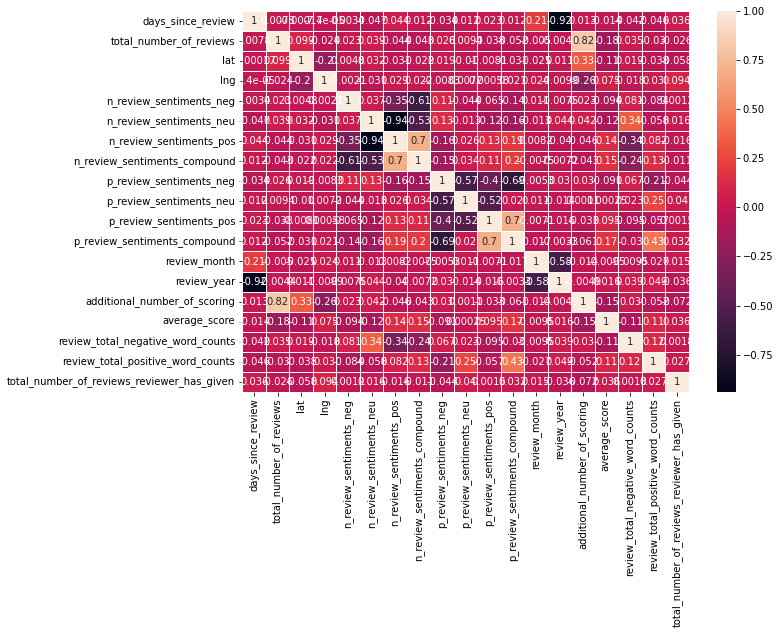

In [390]:
#непрерывные признаки посмотрим по корреляции Пирсона
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(clean_data[num_cols].corr(), annot=True, linewidths=.5, ax=ax)

In [391]:
#удаляем сильно скоррелированные признаки
drop_list = ['additional_number_of_scoring', 'n_review_sentiments_pos', 'review_year']
clean_data.drop(drop_list, axis = 1, inplace=True)

<AxesSubplot:>

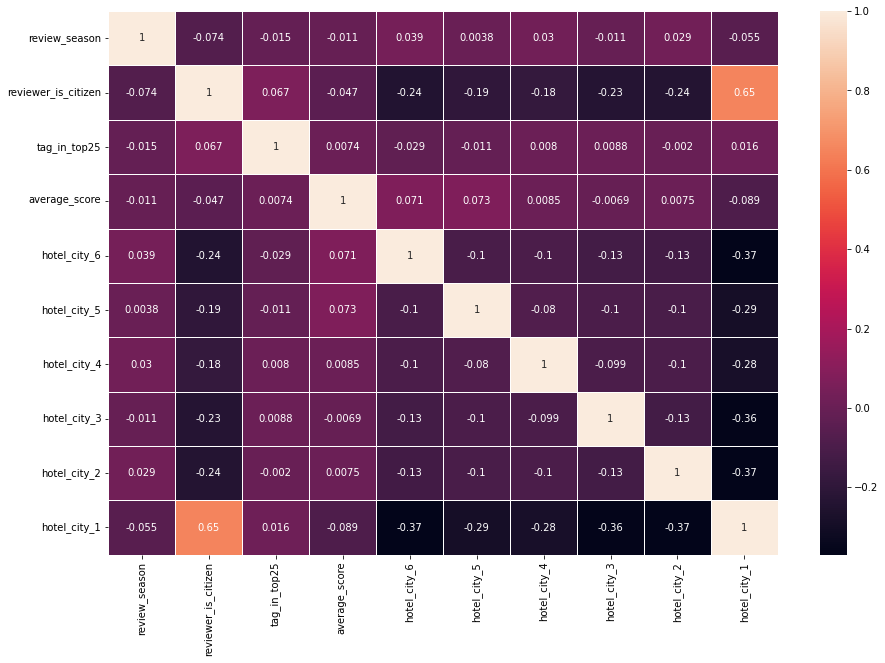

In [392]:
#категориальные признаки посмотрим по корреляции Спирмана
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(clean_data[cat_cols].corr(method = 'spearman'), annot=True, linewidths=.5, ax=ax)

#среди этих признаков допустимая корреляция


In [393]:
clean_data.describe()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,review_month,...,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound,hotel_city_1,hotel_city_2,hotel_city_3,hotel_city_4,hotel_city_5,hotel_city_6
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,...,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000
mean,-0.003956,0.454238,0.248773,0.398646,0.596750,8.396906,0.003943,-0.619144,0.624249,-0.102175,...,0.077988,0.576337,0.345106,0.530013,0.508719,0.115899,0.111183,0.072086,0.075434,0.116680
std,0.782687,1.414446,0.944721,1.278008,1.579203,1.636090,0.593679,1.047908,1.199314,0.670223,...,0.255616,0.273899,0.245653,0.450875,0.499925,0.320104,0.314359,0.258630,0.264090,0.321038
min,-4.571429,-0.428571,-0.852773,-0.647059,-0.285714,2.500000,-1.002841,-3.081014,-0.078171,-1.200000,...,0.000000,0.000000,0.000000,-0.983200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.428571,-0.333333,-0.396819,-0.352941,-0.285714,7.500000,-0.505682,-0.995288,-0.032753,-0.600000,...,0.000000,0.408000,0.145000,0.353500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,8.800000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.588000,0.358000,0.708900,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.571429,0.666667,0.603181,0.647059,0.714286,9.600000,0.494318,0.004712,0.967247,0.400000,...,0.000000,0.752000,0.530000,0.883400,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,19.000000,5.928222,22.588235,50.285714,10.000000,1.071023,0.272426,10.328351,1.000000,...,1.000000,1.000000,1.000000,0.999300,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [398]:
#основные действия завершены, запишем наши данные обратно в hotels
hotels = clean_data.copy()

In [399]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   review_date                                 386803 non-null  datetime64[ns]
 2   average_score                               386803 non-null  float64       
 3   hotel_name                                  386803 non-null  object        
 4   reviewer_nationality                        386803 non-null  object        
 5   negative_review                             386803 non-null  object        
 6   review_total_negative_word_counts           386803 non-null  float64       
 7   total_number_of_reviews                     386803 non-null  float64       
 8   positive_review                             386803 non-null  object       

In [412]:
# убираем признаки "object", 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

#заодно удалим признак review_date
hotels.drop('review_date', axis = 1, inplace=True)

In [413]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']  
      
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [404]:
# непрерывные признаки
num_cols = ['days_since_review',
            'total_number_of_reviews',
            'lat', 
            'lng',
            'n_review_sentiments_neg',
            'n_review_sentiments_neu',
            'n_review_sentiments_compound',
            'p_review_sentiments_neg',
            'p_review_sentiments_neu',
            'p_review_sentiments_pos',
            'p_review_sentiments_compound',
            'review_month',
            'average_score',
            'review_total_negative_word_counts',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given'
]

# категориальные признаки
cat_cols = [#'review_season',
            'reviewer_is_citizen',
            'tag_in_top25',
            #'average_score',
            'hotel_city_6',
            'hotel_city_5',
            'hotel_city_4',
            'hotel_city_3',
            'hotel_city_2',
            'hotel_city_1'  
]

<AxesSubplot:>

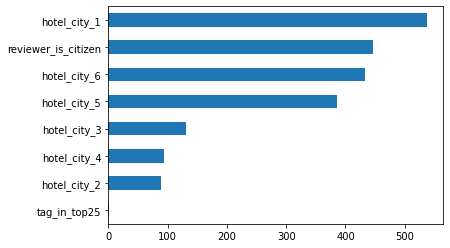

In [405]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

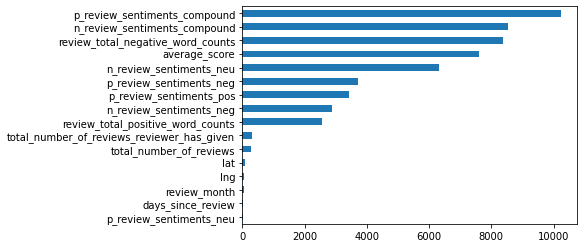

In [406]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [414]:
#как и предполагал, tag_in_top25 ничего не решает
hotels.drop(['tag_in_top25'], axis = 1, inplace=True)

KeyError: "['tag_in_top25'] not found in axis"

In [408]:
#удаляем незначимые количественные признаки
#drop_list = ['lat', 'lng', 'review_month', 'p_review_sentiments_neu', 'days_since_review']
drop_list = ['lat', 'lng', 'review_month'] #в несколько иттераций пришел к удалению только этих трех признаков
hotels.drop(drop_list, axis = 1, inplace=True)

In [411]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   review_date                                 386803 non-null  datetime64[ns]
 2   average_score                               386803 non-null  float64       
 3   hotel_name                                  386803 non-null  object        
 4   reviewer_nationality                        386803 non-null  object        
 5   negative_review                             386803 non-null  object        
 6   review_total_negative_word_counts           386803 non-null  float64       
 7   total_number_of_reviews                     386803 non-null  float64       
 8   positive_review                             386803 non-null  object       

In [415]:
# Заново разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']  
      
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Переходим к обучению модели и проверке корректности предсказаний

In [416]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [417]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12574068660527293
